#Librerie

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn
import plotly.graph_objects as go

<ipython-input-1-3e22d2e96c91>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Input

Creato da
www.investitorecomune.it

In [ ]:
# seleziona i tickers del tuo portafoglio e le percentuali per strumento
stocks = ['SWDA.MI', 'EIMI.MI', 'IMIE.MI', 'SMEA.MI','TQQQ']
pStocks = [0.75, 0.05, 0, 0, 0]
bonds = ['XGLE.MI']
pBonds = [0.1]
commodities = ['SGLD.MI']
pComm = [0.1]
tickers = stocks + bonds + commodities
perc = pStocks + pBonds + pComm

#tickers = ['IVV','TLT','IEF','SHY','GLD']
#perc = [1,0,0,0,0]

#perc = np.array([1/len(tickers)]*len(tickers))

# seleziona periodo di analisi
deltaYear = 3

# percentuali min/max per ottimizzazione
min = 0
max = 1

# seleziona risk free rate
risk_free_rate=0.026

In [ ]:
prezzi = yf.download(tickers)['Adj Close']
prezzi = prezzi.reindex(tickers,axis=1)
vP = np.log(prezzi/prezzi.shift(1))
vP = vP.reindex(tickers,axis=1)
cumVP = vP.cumsum()

[*********************100%***********************]  7 of 7 completed


<Axes: xlabel='Date'>

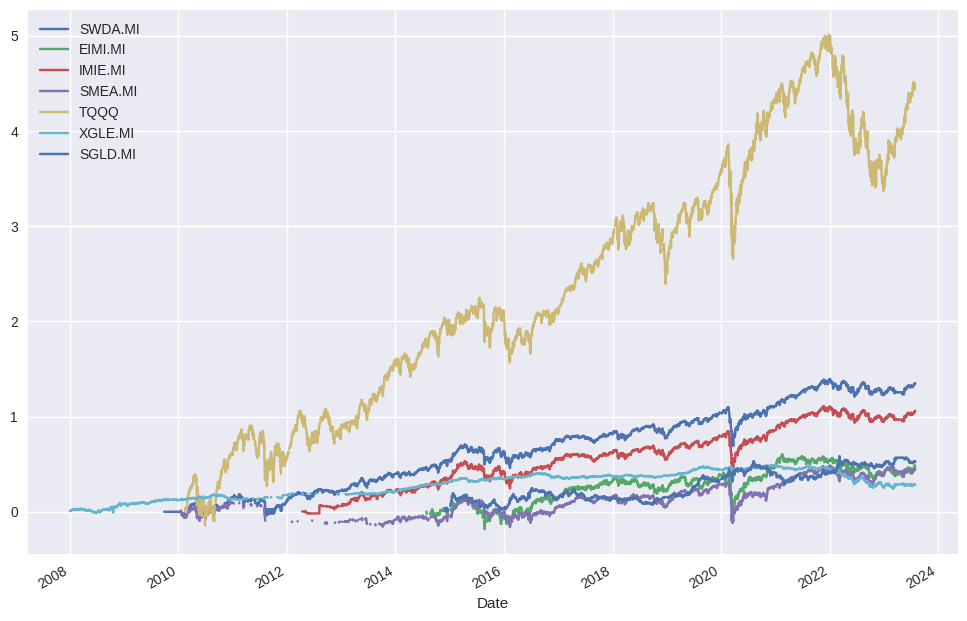

In [ ]:
(vP.cumsum()).plot(figsize=(12, 8))

# Elaborazione portafogli

In [ ]:
def rendimento(percentuali, log_returns):
  return np.sum(log_returns.mean()*percentuali) * 252

In [ ]:
def rendimento_negativo(percentuali, log_returns):
  return -rendimento(percentuali, log_returns)

In [ ]:
def deviazione_standard(percentuali, matrice_cov):
  return np.sqrt(percentuali.T @ matrice_cov @ percentuali)

In [ ]:
def sharpe(percentuali, log_returns, matrice_cov, risk_free_rate):
  return(rendimento(percentuali,log_returns)- risk_free_rate) / deviazione_standard (percentuali, matrice_cov)

In [ ]:
def sharpe_ratio_negativo(percentuali, log_returns, matrice_cov, risk_free_rate):
  return -sharpe(percentuali, log_returns, matrice_cov, risk_free_rate)

In [ ]:
# funzione di massimizzazione dell'indice di sharpe
def max_sharpe(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(sharpe_ratio_negativo, np.array([1/len(tickers)]*len(tickers)), args=(log_returns, matrice_cov, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [ ]:
# funzione di minimizzazione della volatilità
def min_volatilita(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(deviazione_standard, np.array([1/len(tickers)]*len(tickers)), args=(matrice_cov), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [ ]:
# funzione di massimizzazione del rendimento
def max_rendimento(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(rendimento_negativo, np.array([1/len(tickers)]*len(tickers)), args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [ ]:
# recupera prezzi adjusted
adjclose = yf.download(tickers)['Adj Close']

# rendimenti
log_returns=np.log(adjclose/adjclose.shift(1)).dropna()
log_returns=log_returns.reindex(tickers,axis=1)

# covarianza
matrice_cov = log_returns.cov() * 252

[*********************100%***********************]  7 of 7 completed


In [ ]:
rendimento_portafoglio_attuale = rendimento(np.array(perc), log_returns)
volatilita_portafoglio_attuale = deviazione_standard(np.array(perc), matrice_cov)
sharpe_ratio_attuale = sharpe(np.array(perc), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_attuale = log_returns @ np.array(perc)

In [ ]:
rendimento_portafoglio_ottimale = rendimento(max_sharpe(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_ottimale = deviazione_standard(max_sharpe(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_ottimale = sharpe(max_sharpe(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_ottimale = log_returns @ max_sharpe(log_returns, matrice_cov, risk_free_rate)

In [ ]:
rendimento_portafoglio_minvol = rendimento(min_volatilita(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_minvol = deviazione_standard(min_volatilita(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_minvol = sharpe(min_volatilita(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_minval = log_returns @ min_volatilita(log_returns, matrice_cov, risk_free_rate)

In [ ]:
rendimento_portafoglio_maxrend = rendimento(max_rendimento(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_maxrend = deviazione_standard(max_rendimento(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_maxrend = sharpe(max_rendimento(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_maxrend = log_returns @ max_rendimento(log_returns, matrice_cov, risk_free_rate)

# Elaborazione frontiera efficiente

In [ ]:
def portfolio_performance(percentuali, log_returns, matrice_cov):
  rend = rendimento(percentuali, log_returns)
  stdev = deviazione_standard(percentuali, matrice_cov)
  return rend, stdev

In [ ]:
def rend_portafoglio(percentuali, log_returns, matrice_cov):
  return portfolio_performance(percentuali, log_returns, matrice_cov)[0]

In [ ]:
def frontiera_efficiente(log_returns, matrice_cov, target, bound=(min,max)):
  constraints = ({'type':'eq','fun':lambda percentuali:rend_portafoglio(percentuali, log_returns, matrice_cov)-target},
                {'type':'eq','fun':lambda percentuali:np.sum(percentuali)-1})
  bounds = [bound for _ in range(len(tickers))]
  frontiera = minimize(deviazione_standard, np.array([1/len(tickers)]*len(tickers)), args=(matrice_cov), method='SLSQP', constraints=constraints, bounds=bounds)
  return frontiera

In [ ]:
def percentuali_efficienti(percentuali):
  df = pd.DataFrame(percentuali, index=log_returns.mean().index, columns=['allocazione'])
  return df

In [ ]:
def FrontieraEff(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  # portafoglio max sharpe
  act_portfolio = np.array(perc)
  act_rendimento = rendimento(act_portfolio, log_returns)
  act_deviazione_std = deviazione_standard(act_portfolio, matrice_cov)
  act_allocazione = pd.DataFrame(act_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  act_allocazione.allocazione = [round(i*100,0) for i in act_allocazione.allocazione]

  # portafoglio max sharpe
  maxSR_portfolio = max_sharpe(log_returns, matrice_cov, risk_free_rate)
  maxSR_rendimento = rendimento(maxSR_portfolio, log_returns)
  maxSR_deviazione_std = deviazione_standard(maxSR_portfolio, matrice_cov)
  maxSR_allocazione = pd.DataFrame(maxSR_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  maxSR_allocazione.allocazione = [round(i*100,0) for i in maxSR_allocazione.allocazione]

  # portafoglio min stdev
  minvol_portfolio = min_volatilita(log_returns, matrice_cov, risk_free_rate)
  minvol_rendimento = rendimento(minvol_portfolio, log_returns)
  minvol_deviazione_std = deviazione_standard(minvol_portfolio, matrice_cov)
  minvol_allocazione = pd.DataFrame(minvol_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  minvol_allocazione.allocazione = [round(i*100,0) for i in minvol_allocazione.allocazione]

  # portafoglio max rendimento
  maxrend_portfolio = max_rendimento(log_returns, matrice_cov, risk_free_rate)
  maxrend_rendimento = rendimento(maxrend_portfolio, log_returns)
  maxrend_deviazione_std = deviazione_standard(maxrend_portfolio, matrice_cov)
  maxrend_allocazione = pd.DataFrame(maxrend_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  maxrend_allocazione.allocazione = [round(i*100,0) for i in maxrend_allocazione.allocazione]

  # frontiera
  lista_efficienza = []
  perc_efficienti = []
  target = np.linspace(minvol_rendimento, maxrend_rendimento, 100)
  for tgt in target:
    lista_efficienza.append(frontiera_efficiente(log_returns, matrice_cov, tgt)['fun'])
    perc_efficienti.append(frontiera_efficiente(log_returns, matrice_cov, tgt)['x'])

  return act_rendimento, act_deviazione_std, act_allocazione, maxSR_rendimento, maxSR_deviazione_std, maxSR_allocazione, minvol_rendimento, minvol_deviazione_std, minvol_allocazione, maxrend_rendimento, maxrend_deviazione_std, maxrend_allocazione, np.array(lista_efficienza), target, np.array(perc_efficienti)

In [ ]:
def portafogli_eff(perc_efficienti):

  portafogli_efficienti = []
  for i in perc_efficienti:
    peff = pd.DataFrame(i, index=log_returns.mean().index, columns=['allocazione'])
    peff.allocazione = [round(i*100,0) for i in peff.allocazione]
    peff = peff.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')
    portafogli_efficienti.append(peff)

  return portafogli_efficienti

In [ ]:
def grafico_EF(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  act_rendimento, act_deviazione_std, act_allocazione, maxSR_rendimento, maxSR_deviazione_std, maxSR_allocazione, minvol_rendimento, minvol_deviazione_std, minvol_allocazione, maxrend_rendimento, maxrend_deviazione_std, maxrend_allocazione, lista_efficienza, target, perc_efficienti = FrontieraEff(log_returns, matrice_cov, risk_free_rate)

  act_rendimento = round(act_rendimento*100,2)
  act_deviazione_std = round(act_deviazione_std*100,2)
  maxSR_rendimento = round(maxSR_rendimento*100,2)
  maxSR_deviazione_std = round(maxSR_deviazione_std*100,2)
  minvol_rendimento = round(minvol_rendimento*100,2)
  minvol_deviazione_std = round(minvol_deviazione_std*100,2)
  maxrend_rendimento = round(maxrend_rendimento*100,2)
  maxrend_deviazione_std = round(maxrend_deviazione_std*100,2)
  target = [round(tg*100,2) for tg in target]
  lista_efficienza = [round(le*100,2) for le in lista_efficienza]
  portafogli_efficienti = portafogli_eff(perc_efficienti)

  # Portafoglio attuale
  ActPortfolio = go.Scatter(
      name='Portafoglio attuale',
      mode='markers',
      x=[act_deviazione_std],
      y=[act_rendimento],
      marker=dict(color='purple',size=12,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[act_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Max Sharpe Ratio
  MaxSharpe = go.Scatter(
      name='Max Sharpe Ratio',
      mode='markers',
      x=[maxSR_deviazione_std],
      y=[maxSR_rendimento],
      marker=dict(color='red',size=12,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[maxSR_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Min Volatility
  MinVol = go.Scatter(
      name='Minor Rischio',
      mode='markers',
      x=[minvol_deviazione_std],
      y=[minvol_rendimento],
      marker=dict(color='blue',size=8,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[minvol_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Max Rendimento
  MaxRend = go.Scatter(
      name='Massimo Rendimento',
      mode='markers',
      x=[maxrend_deviazione_std],
      y=[maxrend_rendimento],
      marker=dict(color='black',size=8,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[maxrend_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Frontiera Efficiente
  curvaEF = go.Scatter(
      name='Curva di Frontiera',
      mode='lines',
      x=lista_efficienza,
      y=target,
      line=dict(color='black', width=2),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=portafogli_efficienti
  )

  data = [curvaEF,ActPortfolio,MaxSharpe,MinVol,MaxRend]

  layout = go.Layout(
      title='Frontiera Efficiente',
      yaxis=dict(title='Rendimento annuale (%)'),
      xaxis=dict(title='Volatilita annuale (%)'),
      showlegend=False,
      #legend=dict(x=0.85,y=0,traceorder='normal',bgcolor='#E2E2E2',bordercolor='black',borderwidth=1),
      width=1200,
      height=800
  )

  fig=go.Figure(data=data, layout=layout)

  fig.show()

# Portafogli ottimali

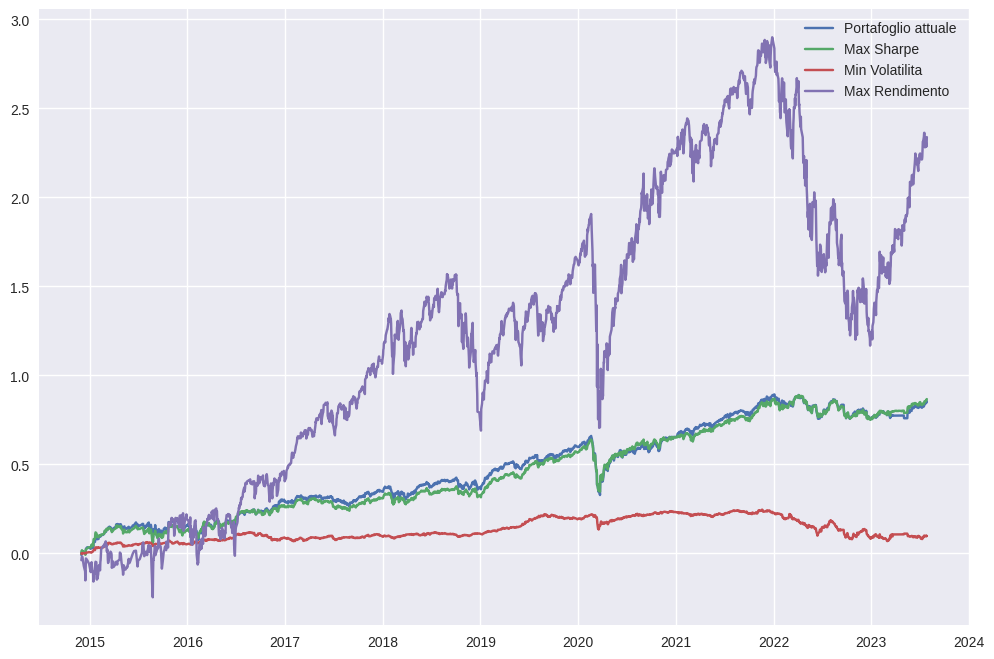

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(equity_line_portafoglio_attuale.cumsum(), label='Portafoglio attuale')
plt.plot(equity_line_portafoglio_ottimale.cumsum(), label='Max Sharpe')
plt.plot(equity_line_portafoglio_minval.cumsum(), label = 'Min Volatilita')
plt.plot(equity_line_portafoglio_maxrend.cumsum(), label= 'Max Rendimento')
plt.legend()
plt.show()

# Frontiera Efficiente

In [ ]:
# grafico_EF(log_returns, matrice_cov, risk_free_rate)

# Elaborazione Backtest Walk Forward

In [ ]:
# Funzione per calcolare il drawdown massimo
def max_drawdown(returns):
    wealth = (1 + returns).cumprod()
    previous_peaks = wealth.cummax()
    drawdowns = (wealth - previous_peaks) / previous_peaks
    return np.min(drawdowns,axis=0)

In [ ]:
# Modello di walk-forward
def analyze_strategy(returns):
    years = returns.index.year.unique()
    in_sample_years = years[:-deltaYear]
    equity_line = pd.DataFrame()

    for year in in_sample_years:
      # trovo allocazione ottimale per il periodo annuale in sample
        minYear = year
        maxYear = year+deltaYear
        in_sample_returns = returns[(returns.index.year >= minYear) & (returns.index.year < maxYear)]
        cov_matrix = in_sample_returns.cov()
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        optimal_weights = max_sharpe(in_sample_returns, cov_matrix, risk_free_rate, bound=(min,max))
        print(f"\nPortfolio {maxYear+1} su frontiera {minYear} {maxYear}")
        for ticker, percentuale in zip(tickers,np.array(optimal_weights)):
          print(f"{ticker}: {percentuale*100:.1f}%")

      # utilizzo l'allocazione ottimale per il portafoglio dell'anno successivo out of sample
        out_of_sample_returns = returns[returns.index.year == maxYear+1]
        out_of_sample_portfolio_returns = out_of_sample_returns @ optimal_weights
        equity_line = pd.concat([equity_line, pd.DataFrame(out_of_sample_portfolio_returns)])

    #out_of_sample_returns = returns[returns.index.year == out_of_sample_year]
    #out_of_sample_portfolio_returns = out_of_sample_returns @ optimal_weights
    #equity_line = equity_line.append(pd.DataFrame(out_of_sample_portfolio_returns))
    #equity_line = pd.concat([equity_line,pd.DataFrame.from_records([out_of_sample_portfolio_returns])], axis=0, ignore_index=True)

    max_drawdown_val = float(max_drawdown(equity_line))
    equity_line_cumulative_returns = np.sum(equity_line.mean())*252
    std_dev = float(np.std(equity_line)*np.sqrt(252))
    sharpe = (equity_line_cumulative_returns - risk_free_rate)/std_dev

    return equity_line, equity_line_cumulative_returns, max_drawdown_val, std_dev, sharpe

# Asset allocation dinamica anno su anno basata su backtest in walk-forward

In [ ]:
# Esegui l'analisi di walk-forward
eq, rendDinamico, maxddDinamico, stdevDinamico, sharpeDinamico = analyze_strategy(log_returns)


Portfolio 2018 su frontiera 2014 2017
SWDA.MI: 41.3%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 0.0%
XGLE.MI: 53.8%
SGLD.MI: 4.9%

Portfolio 2019 su frontiera 2015 2018
SWDA.MI: 61.7%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 38.3%
XGLE.MI: 0.0%
SGLD.MI: 0.0%

Portfolio 2020 su frontiera 2016 2019
SWDA.MI: 28.3%
EIMI.MI: 45.1%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 7.8%
XGLE.MI: 0.0%
SGLD.MI: 18.8%

Portfolio 2021 su frontiera 2017 2020
SWDA.MI: 33.8%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 15.5%
TQQQ: 9.3%
XGLE.MI: 0.0%
SGLD.MI: 41.4%

Portfolio 2022 su frontiera 2018 2021
SWDA.MI: 18.1%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 3.4%
XGLE.MI: 37.4%
SGLD.MI: 41.0%

Portfolio 2023 su frontiera 2019 2022
SWDA.MI: 51.3%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 7.8%
XGLE.MI: 0.0%
SGLD.MI: 40.9%

Portfolio 2024 su frontiera 2020 2023
SWDA.MI: 32.8%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 0.0%
XGLE.MI: 0.0%
SGLD.MI: 67.2%


# Allineamento portafogli statico a dinamico

In [ ]:
# Allineo gli anni dei portafogli
def AllineaAnni(returns, percentuali):
  minAnno = eq.index.min().year
  eqStatica = returns[returns.index.year>=minAnno] @ np.array(percentuali)
  return eqStatica

In [ ]:
def AllineaPortafogli():

  eqStatica = AllineaAnni(log_returns, perc)

  # Ricalcolo le metriche
  RendimentoStatica = np.sum(eqStatica.mean())*252
  DeviazioneStatica = float(np.std(eqStatica)*np.sqrt(252))
  SharpeStatica = (RendimentoStatica - risk_free_rate)/DeviazioneStatica
  DrawdownStatica = max_drawdown(eqStatica)

  return eqStatica, RendimentoStatica, DeviazioneStatica, SharpeStatica, DrawdownStatica

In [ ]:
# stampa metriche portafogli
def stampaMetriche():

  eqStatica, rendStatica, devStatica, SRStatica, DDStatica = AllineaPortafogli()

  # portafoglio asset allocation statica
  print("\nMetriche di portafoglio con asset allocation statica")
  print(f"Rendimento Annuale: {rendStatica*100:.2f}%")
  print(f"Volatilita: {devStatica*100:.2f}%")
  print(f"Indice di Sharpe: {SRStatica:.4f}")
  print(f"Massimo drawdown: {DDStatica*100:.2f}%")
  #print("Asset Allocation:")
  #for ticker, percentuale in zip(tickers,np.array(perc)):
  #  print(f"{ticker}: {percentuale*100:.1f}%")

  # portafoglio asset allocation dinamica
  print("\nMetriche di portafoglio con asset allocation dinamica")
  print(f"Rendimento Annuale: {rendDinamico*100:.2f}%")
  print(f"Volatilita: {stdevDinamico*100:.2f}%")
  print(f"Indice di Sharpe: {sharpeDinamico:.4f}")
  print(f"Massimo drawdown: {maxddDinamico*100:.2f}%")

In [ ]:
def StampaGrafico():
  plt.figure(figsize=(12, 8))
  plt.plot(AllineaAnni(log_returns, perc).cumsum(), label='Asset Allocation statica')
  plt.plot(eq.cumsum(), label='Asset Allocation dinamica')
  plt.legend()
  plt.show()

# Walk Forward

In [ ]:
stampaMetriche()


Metriche di portafoglio con asset allocation statica
Rendimento Annuale: 9.68%
Volatilita: 13.97%
Indice di Sharpe: 0.5066
Massimo drawdown: -29.00%

Metriche di portafoglio con asset allocation dinamica
Rendimento Annuale: 16.64%
Volatilita: 17.50%
Indice di Sharpe: 0.8024
Massimo drawdown: -33.49%


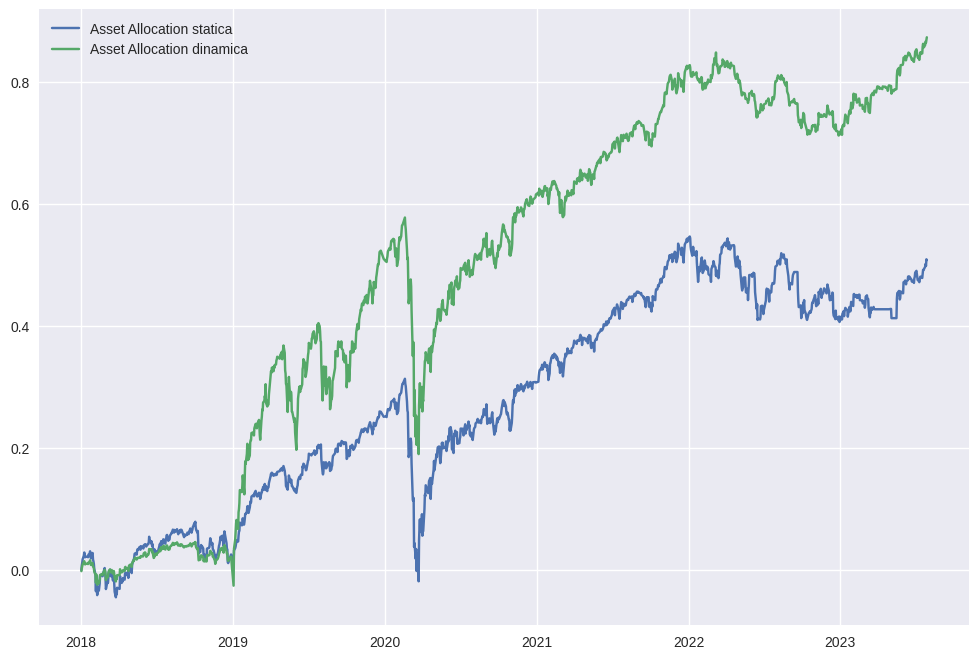

In [ ]:
StampaGrafico()

# Old

In [ ]:
# portafoglio attuale
print("\nMetriche di portafoglio attuale")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_attuale*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_attuale*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_attuale:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,np.array(perc)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio attuale
Rendimento Annuale atteso: 10.95%
Volatilita attesa: 13.70%
Indice di Sharpe atteso: 0.6097
Asset Allocation:
SWDA.MI: 75.0%
EIMI.MI: 5.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 0.0%
XGLE.MI: 10.0%
SGLD.MI: 10.0%


In [ ]:
# portafoglio max sharpe
print("\nMetriche di portafoglio Max Sharpe")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_ottimale*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_ottimale*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_ottimale:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,max_sharpe(log_returns, matrice_cov, risk_free_rate)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio Max Sharpe
Rendimento Annuale atteso: 11.11%
Volatilita attesa: 12.45%
Indice di Sharpe atteso: 0.6839
Asset Allocation:
SWDA.MI: 60.5%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 2.8%
XGLE.MI: 0.0%
SGLD.MI: 36.7%


In [ ]:
# portafoglio min volatilita
print("\nMetriche di portafoglio Min Rischio")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_minvol*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_minvol*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_minvol:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,min_volatilita(log_returns, matrice_cov, risk_free_rate)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio Min Rischio
Rendimento Annuale atteso: 1.26%
Volatilita attesa: 5.11%
Indice di Sharpe atteso: -0.2629
Asset Allocation:
SWDA.MI: 3.2%
EIMI.MI: 0.0%
IMIE.MI: 2.2%
SMEA.MI: 3.7%
TQQQ: 0.0%
XGLE.MI: 85.7%
SGLD.MI: 5.3%


In [ ]:
# portafoglio max rendimento
print("\nMetriche di portafoglio Max Rendimento")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_maxrend*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_maxrend*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_maxrend:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,max_rendimento(log_returns, matrice_cov, risk_free_rate)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio Max Rendimento
Rendimento Annuale atteso: 29.97%
Volatilita attesa: 68.22%
Indice di Sharpe atteso: 0.4012
Asset Allocation:
SWDA.MI: 0.0%
EIMI.MI: 0.0%
IMIE.MI: 0.0%
SMEA.MI: 0.0%
TQQQ: 100.0%
XGLE.MI: 0.0%
SGLD.MI: 0.0%
